In [1]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np

In [30]:
def format_print_str(long_str, line_length=175):
    formatted_str = '\n'.join([long_str[i:i+line_length] for i in range(0, len(long_str), line_length)])
    return formatted_str

def calculate_iou(box1, box2):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    x1_inter = max(x1_1, x1_2)
    y1_inter = max(y1_1, y1_2)
    x2_inter = min(x2_1, x2_2)
    y2_inter = min(y2_1, y2_2)

    if x2_inter > x1_inter and y2_inter > y1_inter:
        area_inter = (x2_inter - x1_inter) * (y2_inter - y1_inter)
    else:
        area_inter = 0

    area_box1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area_box2 = (x2_2 - x1_2) * (y2_2 - y1_2)

    area_union = area_box1 + area_box2 - area_inter

    if area_union == 0:
        return 0
    iou = area_inter / area_union
    return iou

def print_content(content):
    lines = content.splitlines()
    for line in lines:
        print(format_print_str(line))


def show_thinking(ori_image, conversation, ori_gt_boxes):
    for idx, conv in enumerate(conversation):
        conv_role = conv['role']
        content = conv['content']
        if conv_role == 'system':
            continue
        elif idx == 1:
            for _content in content:
                if _content['type'] == 'text':
                    _content = _content['text']
                    _content = _content.split('\n')[0]
                    print ("USER:   ")
                    print_content(_content + '\n\n')
        elif conv_role == 'assistant':
            if isinstance(content, str):
                _content = content
            elif isinstance(content, list):
                for _content in content:
                    if _content['type'] == 'text':
                        _content = _content['text']
            else:
                continue
            print ("ASSISTANT:   ")
            print_content(_content)
            if "<tool_call>" in _content:
                _bbox_str = _content.split("<tool_call>")[1].split("</tool_call>")[0]
                _bbox = eval(_bbox_str)['arguments']
                for _box in [_bbox]:
                    _box = _box['bbox_2d']
                    x1, y1, x2, y2 = _box
                    _crop_img = ori_image.crop((x1, y1, x2, y2))
                    max_iou = 0.
                    for _gt_box in ori_gt_boxes:
                        _gt_x1, gt_y1, gt_w, gt_h = _gt_box
                        _gt_x2, gt_y2 = _gt_x1 + gt_w, gt_y1 + gt_h
                        _gt_box = (_gt_x1, gt_y1, _gt_x2, gt_y2)
                        iou = calculate_iou(_box, _gt_box)
                        if iou > max_iou:
                            max_iou = iou
                    print ('IOU: ', max_iou)
                    print ('Area Size: ', _box[2] - _box[0], _box[3] - _box[1], (_box[2] - _box[0]) * (_box[3] - _box[1]), 4*28*28)

                    plt.imshow(_crop_img)
                    plt.axis('off')
                    plt.show()
            print_content('\n\n')
            if "</answer>" in _content:
                break
        else:
            if isinstance(content, str):
                _content = content
            elif isinstance(content, list):
                for _content in content:
                    if _content['type'] == 'text':
                        _content = _content['text']
            else:
                continue

            print ("USER:   ")
            print_content(_content + '\n\n')


In [8]:
root_path = '/home/ubuntu/work/eval_data/vstar_bench'
json_path = '/home/ubuntu/work/laughing-potato/eval_results/qwen/result_relative_position_qwen.jsonl'
json_path = '/home/ubuntu/work/laughing-potato/eval_results/qwen/result_direct_attributes_qwen.jsonl'

if 'direct_attributes' in json_path:
    root_path = os.path.join(root_path, 'direct_attributes')
else:
    root_path = os.path.join(root_path, 'relative_position')


In [9]:
with open(json_path, 'r') as f:
    lines = f.readlines()
    lines = [json.loads(line) for line in lines]
line_map = {}
image_list = []
for line in lines:
    line_map[line['image']] = line
    image_list.append(line['image'])

In [10]:
# error_list = []
# for idx, image in enumerate(image_list):
#     acc = line_map[image]['acc']
#     if acc == 0:
#         error_list.append(idx)

# print ('Error List: ', error_list)

image:  sa_10919.jpg
question: What is the color of the SUV car?
answer: The color of the SUV car is silver.
pred_ans: A. The color of the SUV car is silver.
image:  sa_10919.jpg
question: What is the color of the SUV car?
answer: The color of the SUV car is silver.
SUV car
[1403, 723, 1466, 755]


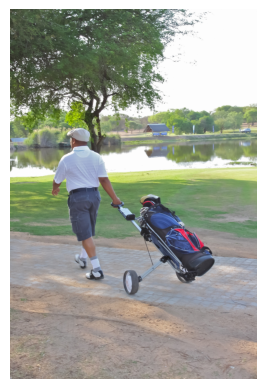

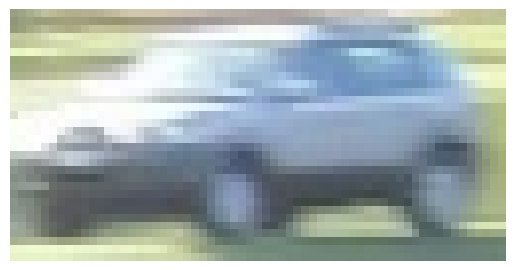

USER:   
Question: What is the color of the SUV car?

ASSISTANT:   
<think>The image shows a person walking with a golf bag on a path near a lake. In the background, there is a car visible on the right side of the image. The car appears to be 
silver in color. The question asks for the color of the SUV car, and the options provided are silver, black, red, and blue. Since the car in the image is silver, the correct a
nswer is A.</think>  
<tool_call>
{"name": "image_zoom_in_tool", "arguments": {"bbox_2d": [1410, 718, 1476, 753], "label": "SUV car"}}
IOU:  0.6349206349206349
Area Size:  66 35 2310 3136


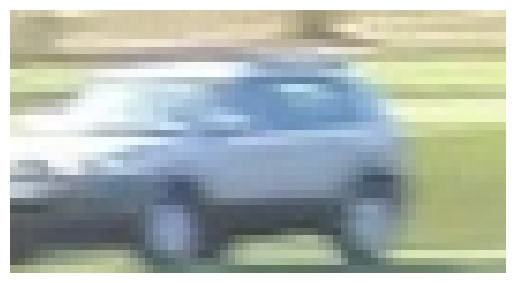



USER:   

Think first, call **image_zoom_in_tool** if needed, then answer. Format strictly as:  <think>...</think>  <tool_call>...</tool_call> (if tools needed)  <answer>...</answer> 

ASSISTANT:   
<think>The image zoom-in tool confirmed that the car in the background is silver. Therefore, the correct answer is A.</think>  
<answer>A. The color of the SUV car is silver.</answer>  
<tool_call>
{"name": "image_zoom_in_tool", "arguments": {"bbox_2d": [1410, 718, 1476, 753], "label": "SUV car"}}
IOU:  0.6349206349206349
Area Size:  66 35 2310 3136


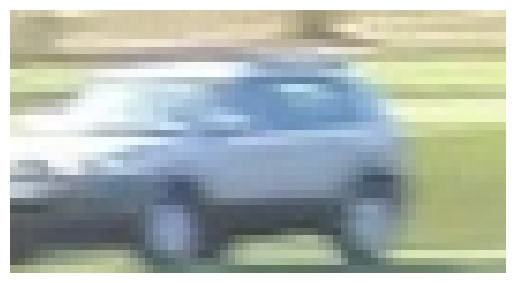

In [37]:
line_id = 52

tosee_img = image_list[line_id]
# tosee_img = "sa_25219.jpg"
img_path = os.path.join(root_path, tosee_img)
question = line_map[tosee_img]['question']
answer = line_map[tosee_img]['answer']
pred_ans = line_map[tosee_img]['pred_ans']
pred_output = line_map[tosee_img]['pred_output']
# acc = line_map[tosee_img]['acc']
print ('image: ', tosee_img)
print (f"question: {question}")
print (f"answer: {answer}")
print (f"pred_ans: {pred_ans}")

# from pprint import pprint
# pprint (pred_output)
# print (f"acc: {acc}")
ori_image_path = os.path.join(root_path, tosee_img)
ori_json_path = os.path.join(root_path, tosee_img.replace('.jpg', '.json'))
ori_json = json.load(open(ori_json_path, 'r'))
ori_gt_name = ori_json['target_object']
ori_gt_boxes = ori_json['bbox']

box_color = (255, 0, 0)
border_width = 2

print ('image: ', tosee_img)
print (f"question: {question}")
print (f"answer: {answer}")
# print (f"pred_ans: {pred_ans}")
# print (f"acc: {acc}")

ori_image = Image.open(ori_image_path)
draw = ImageDraw.Draw(ori_image)
crop_imgs = []
for idx, _box in enumerate(ori_gt_boxes):
    _box = [_box[0], _box[1], _box[2] + _box[0], _box[3] + _box[1]]
    print (f"{ori_gt_name[idx]}")
    print (_box)
    x1, y1, x2, y2 = _box
    _crop_img = ori_image.crop((x1, y1, x2, y2))
    crop_imgs.append(_crop_img)

plt.imshow(ori_image)
plt.axis('off')
plt.show()

for i, _crop_img in enumerate(crop_imgs):
    plt.subplot(1, len(crop_imgs), i + 1)
    plt.imshow(_crop_img)
    plt.axis('off')
plt.show()

show_thinking(ori_image, pred_output, ori_gt_boxes)